In [5]:
# подгружаем все нужные пакеты
import pandas as pd
import numpy as np




import warnings
warnings.filterwarnings("ignore")

#plt.rcParams['figure.figsize'] = 10, 7.5
#plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Vernada' # Ubuntu

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

# чтобы был русский шрифт
from matplotlib import rc

font = {'family': 'Vernada', #Droid Sans
        'weight': 'normal'}
rc('font', **font)

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

**Реализация стекинга**

In [17]:
class MyStacking(BaseEstimator, ClassifierMixin):
  """Стекинг моделей из sklearn"""
  def __init__(self, models, ens_model, ) -> None:
    self.models = models # базовые модели для стекинга
    self.ens_model = ens_model # мета-модель (финальная модель)
    self.n = len(models)
    self.valid = None # матрица мета-признаков

  def fit(self, X, y=None, p=0.25, cv=3, err=0.01, random_state=None):
        """
        Обучение стекинга
        p - в каком отношении делить на обучение / тест
            если p = 0 - используем всё обучение!
        cv  (при p=0) - сколько фолдов использовать
        err (при p=0) - величина случайной добавки к метапризнакам
        random_state - инициализация генератора

        """
        if p > 0:
          # делим на обучение и тест
          train, valid, y_train, y_valid = train_test_split(X, y, test_size=p, random_state=random_state)
          self.valid = np.zeros((valid.shape[0], self.n)) # иницилизация матрицы для обучения мета-моделей
          for t, clf in enumerate(self.models):
            clf.fit(train, y_train)
            self.valid[:, t] = clf.predict(valid)

          self.ens_model.fit(self.valid, y_valid)

        else: # используем все обучения
          # для регуляризации - берём случайные добавки
          self.valid = err*np.random.randn(X.shape[0], self.n)

          for t, clf in enumerate(self.models):
            self.valid[:, t] += cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method = 'predict')
            clf.fit(X, y)

          self.ens_model.fit(self.valid, y)

        return self


  def predict(self, X, y=None):
    X_meta = np.zeros((X.shape[0], self.n)) # заполнения матрицы мета-признаков
    for t, clf in enumerate(self.models):
      X_meta[:, t] = clf.predict(X)

    a = self.ens_model.predict(X_meta)

    return a



**Отрисовка признаковых пространств**

In [7]:
from sklearn.metrics import roc_auc_score

def run_and_plot(clf, X, y, label):
    # plt.figure(figsize=(6, 5))

    a = clf.predict(X)

    xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))


    print (label + ' AUC-ROC  = ' + str( roc_auc_score(y, a) ))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 7))
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 20), cmap=plt.cm.bwr, alpha=0.3) # plt.cm.Blues_r cmap=plt.cm.Blues_r)
    #a_ = plt.contour(xx, yy, Z, levels=[threshold], linewidths=1, colors='black')
    #plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='#CCDDFF')

    # не всё... :100
    plt.scatter(X[:300, 0], X[:300, 1], c=y[:300], s=20, alpha=1.0)
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    # plt.axis('tight')
    plt.axis('off')
    plt.title(label)

**Пример на простом датасете**

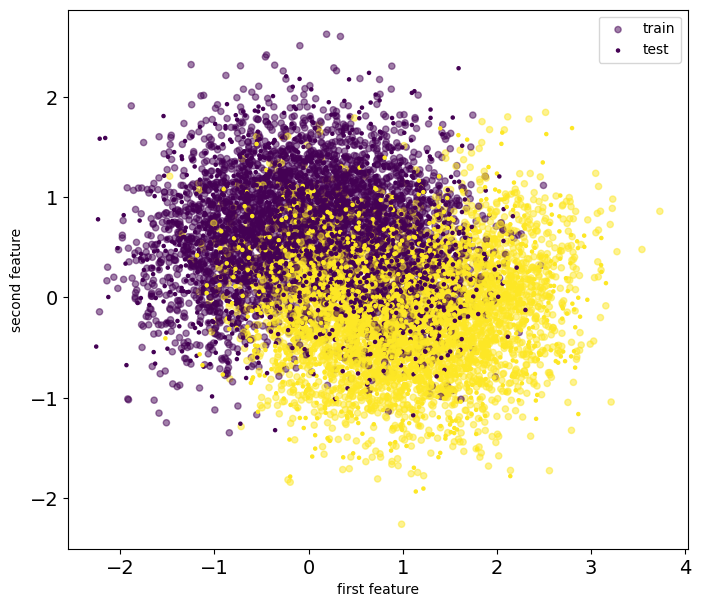

In [10]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_classification

X, y = make_moons(10000, noise=0.5) #X1, y1 = make_classification(100)


train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.7, random_state=1999)

plt.figure(figsize=(8, 7))
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=20, alpha=0.5, label='train')
plt.scatter(test_X[:, 0], test_X[:, 1], c=test_y, s=5, alpha=1.0, label='test')
plt.xlabel("first feature")
plt.ylabel("second feature")
plt.legend()
plt.show()

3NN AUC-ROC  = 0.8399384057052961
10NN AUC-ROC  = 0.8815285573750232
ridge-0.01 AUC-ROC  = 0.8895948050262297
ridge-1.1 AUC-ROC  = 0.889593026899939
ridge-100.1 AUC-ROC  = 0.889393432223827
rf-d1 AUC-ROC  = 0.7858951465598367
rf-d5 AUC-ROC  = 0.9032014719329433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 2
[LightGBM] [Info] Start training from score 0.503000
gbm-d2 AUC-ROC  = 0.9023873123576666
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds

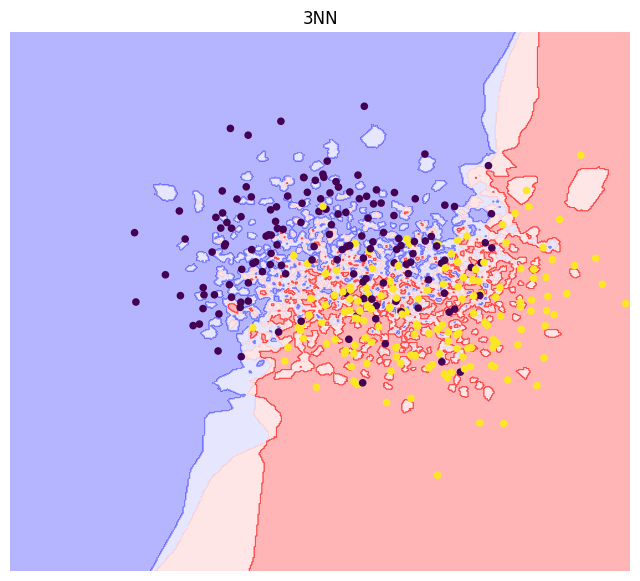

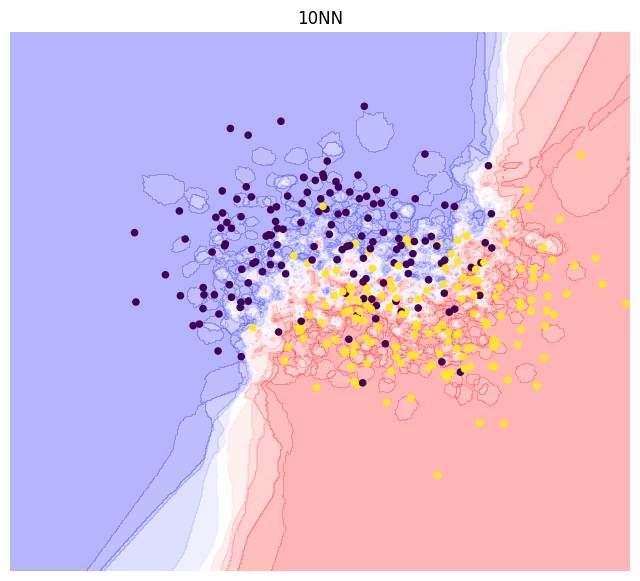

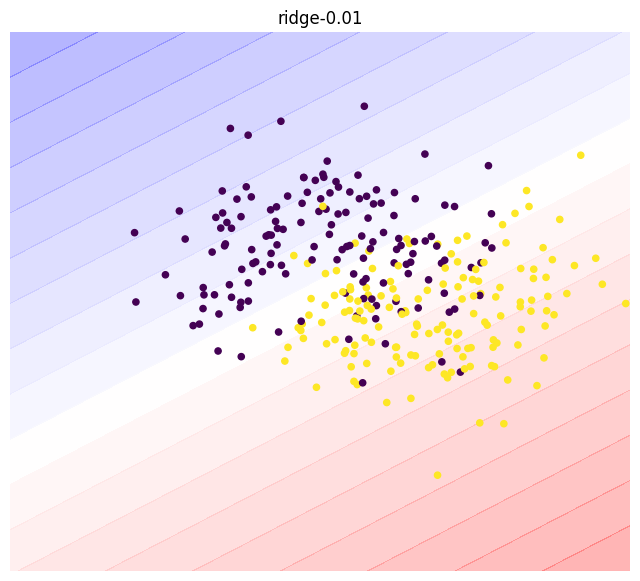

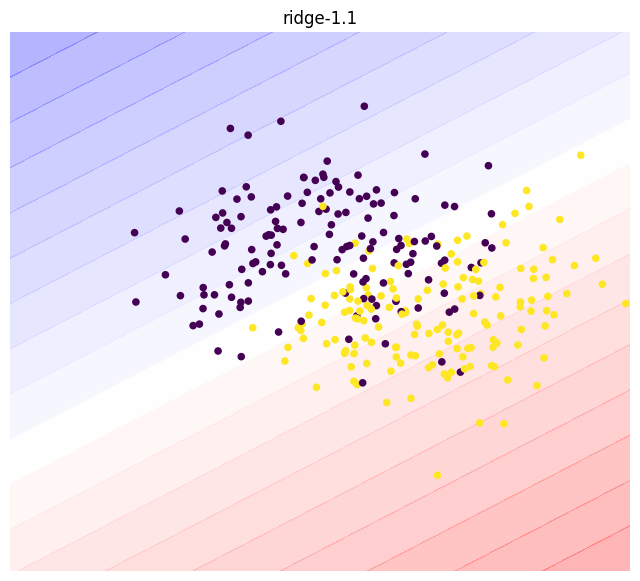

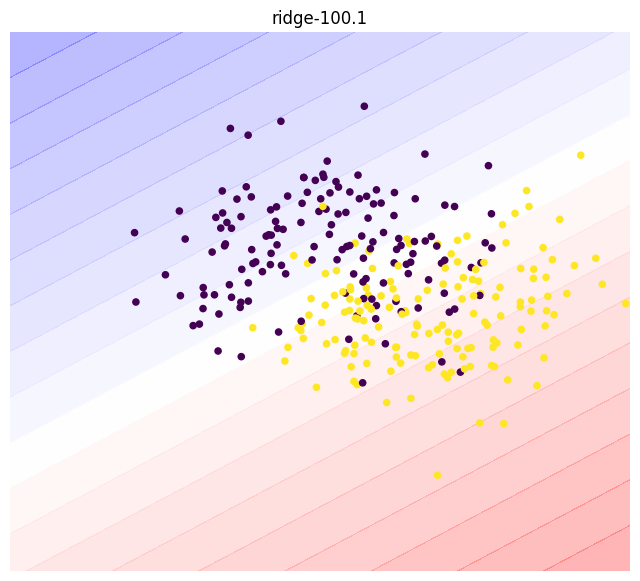

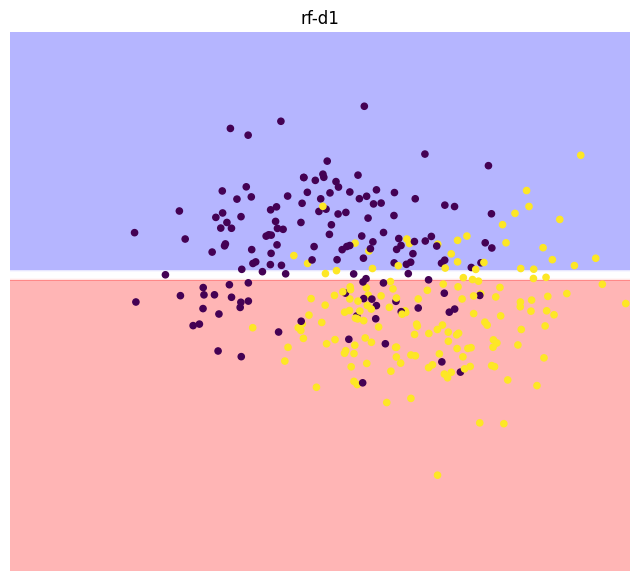

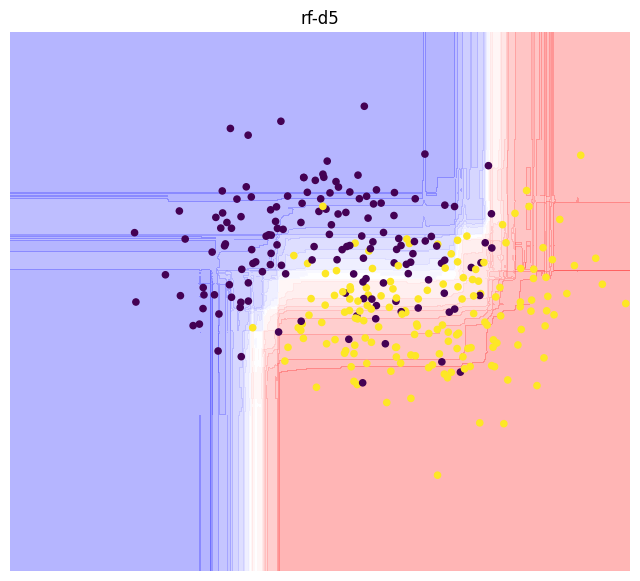

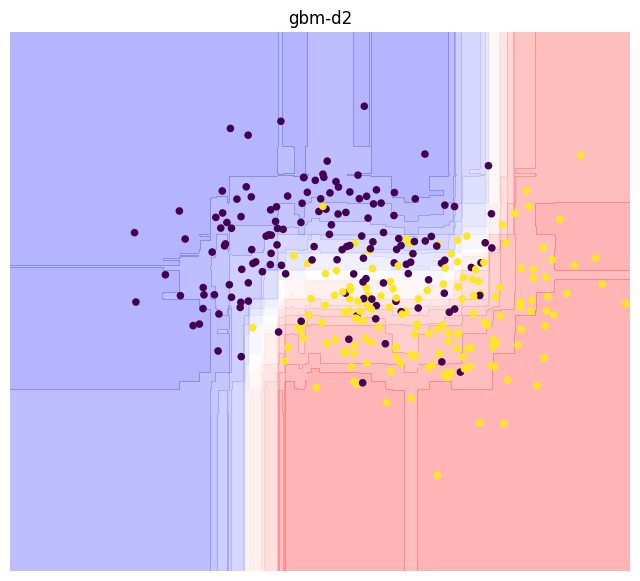

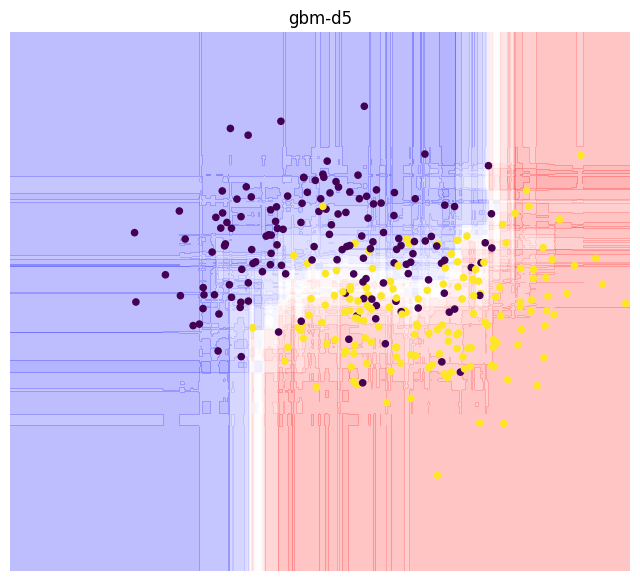

In [13]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

knn1 = KNeighborsRegressor(n_neighbors=3)
knn1.fit(train_X, train_y)
run_and_plot(knn1, test_X, test_y, '3NN')

knn2 = KNeighborsRegressor(n_neighbors=10)
knn2.fit(train_X, train_y)
run_and_plot(knn2, test_X, test_y, '10NN')


rg0 = Ridge(alpha=0.01)
rg0.fit(train_X, train_y)
run_and_plot(rg0, test_X, test_y, 'ridge-0.01')

rg1 = Ridge(alpha=1.1)
rg1.fit(train_X, train_y)
run_and_plot(rg1, test_X, test_y, 'ridge-1.1')

rg2 = Ridge(alpha=100.1)
rg2.fit(train_X, train_y)
run_and_plot(rg2, test_X, test_y, 'ridge-100.1')


rf1 = RandomForestRegressor(n_estimators=100, max_depth=1)
rf1.fit(train_X, train_y)
run_and_plot(rf1, test_X, test_y, 'rf-d1')

rf2 = RandomForestRegressor(n_estimators=100, max_depth=5)
rf2.fit(train_X, train_y)
run_and_plot(rf2, test_X, test_y, 'rf-d5')


gbm1 = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.05, max_depth=2, n_estimators=200, nthread=-1, objective='regression')
gbm1.fit(train_X, train_y)
run_and_plot(gbm1, test_X, test_y, 'gbm-d2')

gbm2 = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.05, max_depth=5, n_estimators=200, nthread=-1, objective='regression')
gbm2.fit(train_X, train_y)
run_and_plot(gbm2, test_X, test_y, 'gbm-d5')

**Запускаем блендинг и стекинг**

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5250, number of used features: 2
[LightGBM] [Info] Start training from score 0.503619
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5250, number of used features: 2
[LightGBM] [Info] Start training from score 0.503619
[LightGBM] [Warning] No further splits with positive gain, bes

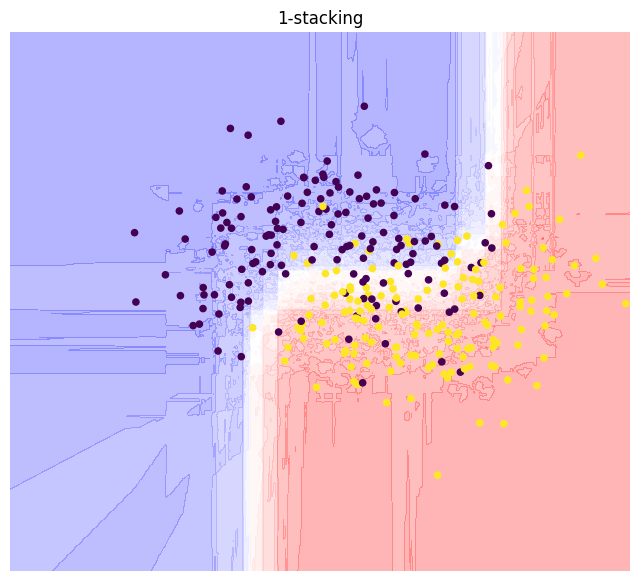

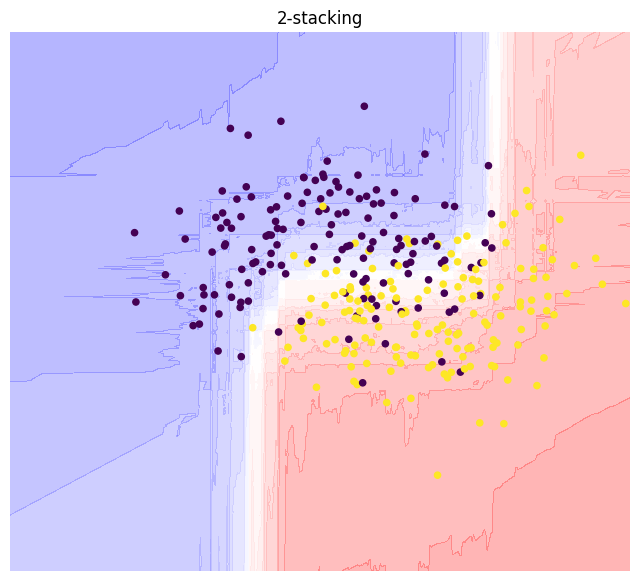

In [18]:
models = [knn1, knn2,rg1, rg2, rf1, rf2, gbm1, gbm2] # , rf3
ens_model = Ridge()
s1 = MyStacking(models, ens_model)
s1.fit(train_X, train_y)
run_and_plot(s1, test_X, test_y, '1-stacking')


s2 = MyStacking(models, ens_model)
s2.fit(train_X, train_y, p=-1)
run_and_plot(s2, test_X, test_y, '2-stacking')

1-stacking AUC-ROC  = 0.9030934507607935

2-stacking AUC-ROC  = 0.9040416366052191

**Несколько блендингов подряд**

In [19]:
# models = [knn3, knn5, knn10, rg0, rg1, rg2, rf1, rf2, rf3]
ens_model = Ridge(0.001)
s1 = MyStacking(models, ens_model)
a = 0
e = []
for t in range(10):
    s1.fit(train_X, train_y, p=0.4)
    a += s1.predict(test_X, train_y)

    auc = roc_auc_score(test_y, a)
    print (auc)
    e.append(auc)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 4200, number of used features: 2
[LightGBM] [Info] Start training from score 0.500952
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 4200, number of used features: 2
[LightGBM] [Info] Start training from score 0.500952
[LightGBM] [Warning] No further splits with positive gain, bes

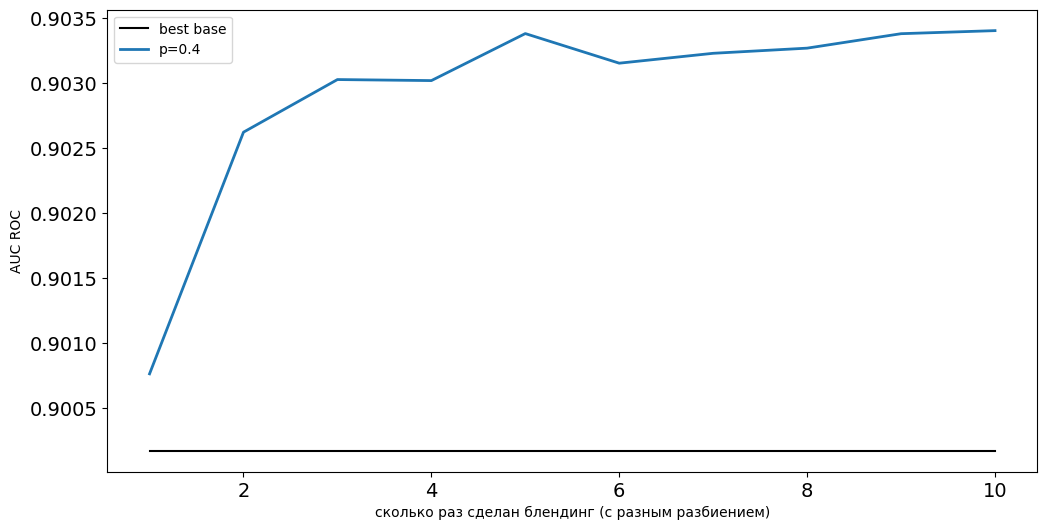

In [20]:
e4 = e
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1,11), 0.900175155867 + 0*np.arange(1,11), c='black', label='best base')
#plt.plot(np.arange(1,11), e1, label='p=0.1', lw=2)
#plt.plot(np.arange(1,11), e2, label='p=0.2', lw=2)
#plt.plot(np.arange(1,11), e3, label='p=0.3', lw=2)
plt.plot(np.arange(1,11), e4, label='p=0.4', lw=2)
plt.xlabel(u'сколько раз сделан блендинг (с разным разбиением)')
plt.ylabel('AUC ROC')
plt.legend()

**Несколько стекингов подряд**

In [21]:
# models = [knn3, knn5, knn10, rg0, rg1, rg2, rf1, rf2, rf3]
ens_model = Ridge(0.001)
s1 = MyStacking(models, ens_model)
a = 0
e = []
for t in range(10):
    s1.fit(train_X, train_y, p=-1)
    a += s1.predict(test_X, train_y)

    auc = roc_auc_score(test_y, a)
    print (auc)
    e.append(auc)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 2
[LightGBM] [Info] Start training from score 0.503000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 2
[LightGBM] [Info] Start training from score 0.503000
[LightGBM] [Warning] No further splits with positive gain, bes

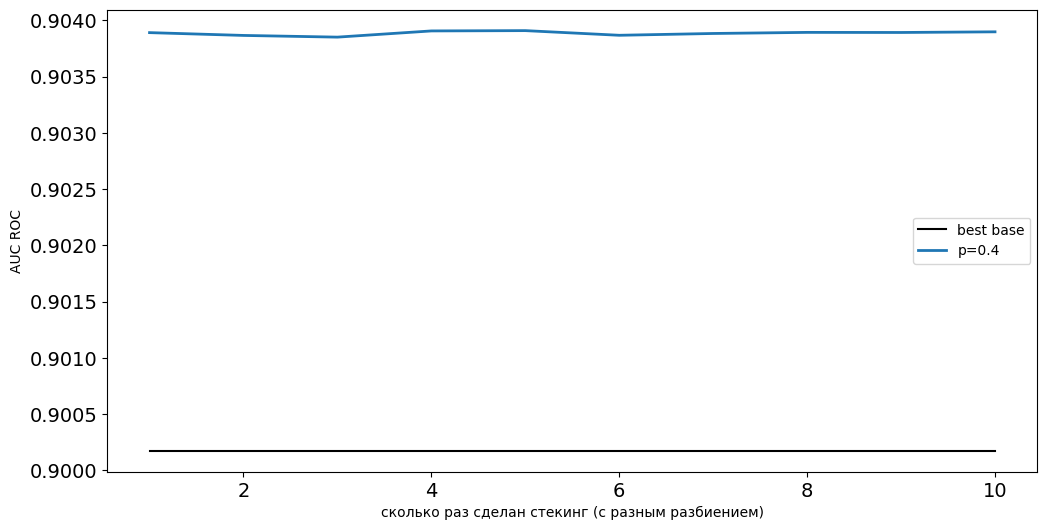

In [23]:
e5 = e
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1,11), 0.900175155867 + 0*np.arange(1,11), c='black', label='best base')
#plt.plot(np.arange(1,11), e1, label='p=0.1', lw=2)
#plt.plot(np.arange(1,11), e2, label='p=0.2', lw=2)
#plt.plot(np.arange(1,11), e3, label='p=0.3', lw=2)
plt.plot(np.arange(1,11), e5, label='p=0.4', lw=2)
plt.xlabel(u'сколько раз сделан стекинг (с разным разбиением)')
plt.ylabel('AUC ROC')
plt.legend()

**Варьируем число фолдов**

In [24]:
# models = [knn3, knn5, knn10, rg0, rg1, rg2, rf1, rf2, rf3]
ens_model = Ridge(0.001)

s1 = MyStacking(models, ens_model)
a = 0
e = []
for t in range(2, 11):
    s1.fit(train_X, train_y, p=-1, cv=t, err=0.00)
    a = s1.predict(test_X, train_y)
    auc = roc_auc_score(test_y, a)
    print (auc)
    e.append(auc)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 2
[LightGBM] [Info] Start training from score 0.503000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 2
[LightGBM] [Info] Start training from score 0.503000
[LightGBM] [Warning] No further splits with positive gain, bes

In [26]:
for i in range(2, 11):
  print('cv = {} roc_auc = {}'.format(i, e[i - 2]))

cv = 2 roc_auc = 0.9029431990892437
cv = 3 roc_auc = 0.9037420223252646
cv = 4 roc_auc = 0.9034588557134975
cv = 5 roc_auc = 0.9035553190647589
cv = 6 roc_auc = 0.903468190876523
cv = 7 roc_auc = 0.9035228682599568
cv = 8 roc_auc = 0.9031623531545516
cv = 9 roc_auc = 0.9033041587262216
cv = 10 roc_auc = 0.903431739287567


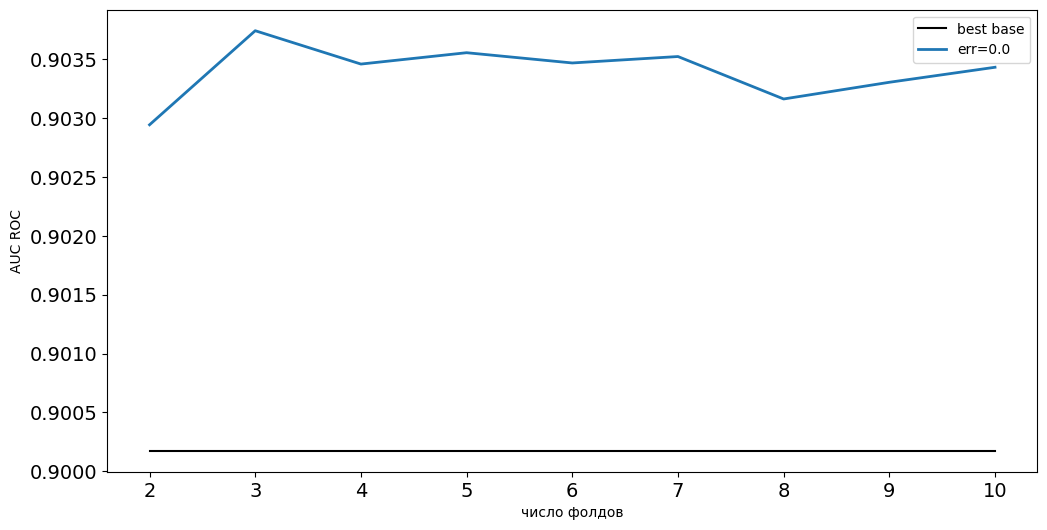

In [28]:
e1 = e
plt.figure(figsize=(12, 6))
plt.plot(np.arange(2,11), 0.900175155867 + 0*np.arange(2,11), c='black', label='best base')
plt.plot(np.arange(2,11), e1, label='err=0.0', lw=2)
#plt.plot(np.arange(2,11), e3, label='err=0.01', lw=2)
# plt.plot(np.arange(2,11), e4, label='p=0.4', lw=2)
plt.xlabel(u'число фолдов')
plt.ylabel('AUC ROC')
plt.legend()

In [29]:
from xgboost import XGBRegressor

In [31]:
final_estimator = XGBRegressor(n_estimators=200, max_depth=2, learning_rate=0.05, objective='reg:squarederror')
s3 = MyStacking(models, final_estimator)
s3.fit(train_X, train_y, p=-1, cv=3, err=0.00)
a = s3.predict(test_X)
auc = roc_auc_score(test_y, a)
print(auc)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 2
[LightGBM] [Info] Start training from score 0.503000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 2
[LightGBM] [Info] Start training from score 0.503000
[LightGBM] [Warning] No further splits with positive gain, bes